## NLP (Natural Language Processing) with Python

**Summery**

* Two class categorization problem
* Training set : 200 training instances
* Testing set  : 100 test instances
* Each document is one line of text
* Fields are seperated by the tab '\t' character
> CLASS \t TITLE \t DATE \t BODY

* CLASS is either +1 or -1

<br/>

**Objective**

Predict the labels for the 100 test instances.


## Process

In [1]:
# Importing the NLTK package
import nltk

In [3]:
# Download the stopwords
#nltk.download_shell()

### Importing the Data

Data sets needed for the process is included inside the `dataset` directory in the root.

As the summery indicates we have **TSV (Tab Seperated Values)** as the documents. 

Instead of parsing TSV manually using Python, I will take advantage of pandas.

In [4]:
# Importing the Pandas package
import pandas as pd

In [5]:
# Parse using read_csv
news = pd.read_csv('dataset/trainset.txt', sep='\t', names=['CLASS', 'TITLE', 'DATE', 'BODY'])

In [6]:
news.head()

,CLASS,TITLE,DATE,BODY
0,1,JAPAN FIRM PLANS TO SELL U.S. FARMLAND TO JAP...,"MORIOKA, Japan, March 12 -",A Japanese real estate company said it will ...
1,-1,NORTH BH SETS ONE-FOR-FIVE OFFER FOR NORGOLD ...,"MELBOURNE, March 12 -",North Broken Hill Holdings Ltd & lt;NBHA.ME ...
2,-1,OUTOKUMPU IN COPPER DEAL WITH IBERICA DEL COBRE,"HELSINKI, June 26 -",Finland's state-owned mining company Outokum...
3,1,ROTTERDAM GRAIN HANDLER SAYS PORT BALANCE ROSE,"ROTTERDAM, April 13 -","Graan Elevator Mij, GEM, said its balance in..."
4,1,U.S. SENATE PANEL VOTES TO LIMIT COUNTY LOAN ...,(NO DATE),(NO TEXT)


### Exploratory Data Analysis

In [7]:
news.describe()

,CLASS
count,200.000000
mean,0.020000
std,1.002309
min,-1.000000
25%,-1.000000
50%,1.000000
75%,1.000000
max,1.000000


Now we can use **groupby** to describe by *CLASS*, this way we can begin to think about the features that separate **+1** and **-1**

In [8]:
news.groupby('CLASS').describe()

BODY                         DATE                                     \
      count unique        top freq count unique                    top freq   
CLASS                                                                         
-1       98     97  (NO TEXT)    2    98     89   NEW YORK, April 13 -    2   
 1      102     93  (NO TEXT)   10   102     80              (NO DATE)   10   

      TITLE                                                                 
      count unique                                                top freq  
CLASS                                                                       
-1       98     98    EC COMMISSION HAS OPEN ATTITUDE ON STEEL QUOTAS    1  
 1      102    102   JAPAN MAY INCREASE ITS BRAZILIAN SOYBEAN PURC...    1

In the training set we have 98 instances of **-1** class. The remaining 102 instances bear the class of **+1**.

We have two instances of class -1 that does not have a body and another 10 instances of class +1 without a body.

Also, class +1 contains 10 instances where there is a no date specified.

All the class instances contains a title.

> Therefore we can assume TITLE plays a bigger role when it comes to classifying these news articles.

Now we have to check the if lenght of the body plays a part in the classification.

First lets create a addtional column contaning the body length. 

In [9]:
news['BODY LENGTH'] = news['BODY'].apply(len)

In [10]:
news.head()

,CLASS,TITLE,DATE,BODY,BODY LENGTH
0,1,JAPAN FIRM PLANS TO SELL U.S. FARMLAND TO JAP...,"MORIOKA, Japan, March 12 -",A Japanese real estate company said it will ...,1120
1,-1,NORTH BH SETS ONE-FOR-FIVE OFFER FOR NORGOLD ...,"MELBOURNE, March 12 -",North Broken Hill Holdings Ltd & lt;NBHA.ME ...,1154
2,-1,OUTOKUMPU IN COPPER DEAL WITH IBERICA DEL COBRE,"HELSINKI, June 26 -",Finland's state-owned mining company Outokum...,597
3,1,ROTTERDAM GRAIN HANDLER SAYS PORT BALANCE ROSE,"ROTTERDAM, April 13 -","Graan Elevator Mij, GEM, said its balance in...",534
4,1,U.S. SENATE PANEL VOTES TO LIMIT COUNTY LOAN ...,(NO DATE),(NO TEXT),9


### Data Visualization

In [11]:
# Importing the Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
%matplotlib inline

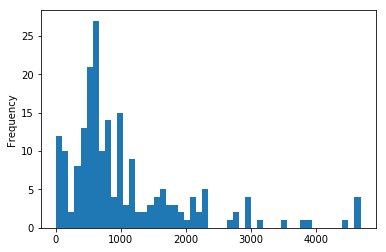

In [13]:
news['BODY LENGTH'].plot.hist(bins=50)

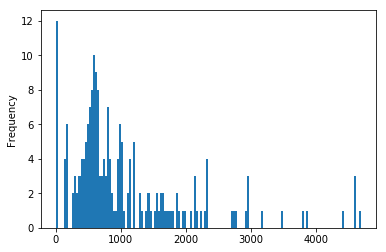

In [13]:
news['BODY LENGTH'].plot.hist(bins=150)

According to the above Histograms we can identify body length usually revolves around 0-1000 area, with exception some of the news Body lengths exceeding 4000 words.

In [14]:
# Overview of the Lengths
news['BODY LENGTH'].describe()

count     200.000000
mean     1059.140000
std       952.623023
min         9.000000
25%       499.500000
50%       738.500000
75%      1320.500000
max      4689.000000
Name: BODY LENGTH, dtype: float64

Now we need to identify whether the BODY LENGTH have a effect on the CLASS classification.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001B85D8A5B70>,
      dtype=object)

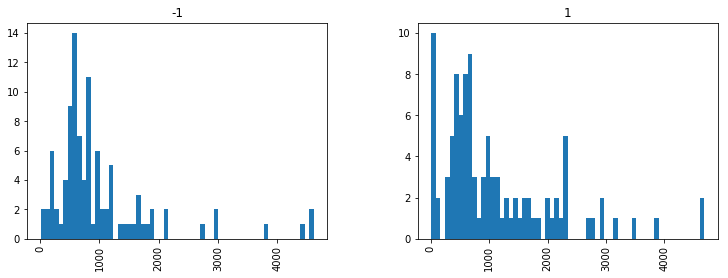

In [15]:
news.hist(column='BODY LENGTH', by='CLASS', bins=60, figsize=(12,4))

#### Using FacetGrid from the seaborn library to create a grid of 2 histograms of BODY LENGTH based off of the CLASS values.

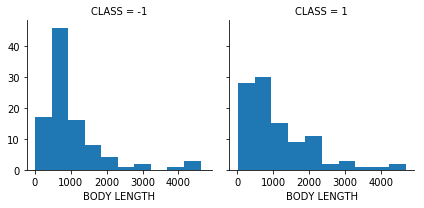

In [16]:
g = sns.FacetGrid(news,col='CLASS')
g.map(plt.hist,'BODY LENGTH')

#### Creating a boxplot of BODY LENGTH for each CLASS.

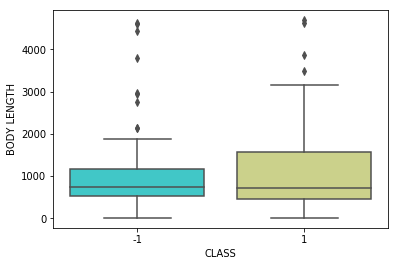

In [17]:
sns.boxplot(x='CLASS', y='BODY LENGTH', data=news, palette='rainbow')

#### Creating a countplot of the number of occurrences for each type of CLASS.

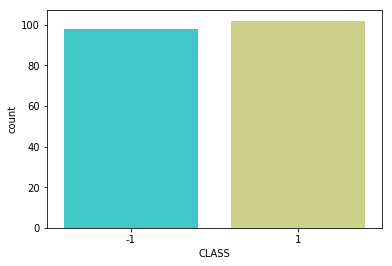

In [18]:
sns.countplot(x='CLASS',data=news,palette='rainbow')

As the histograms indicate we cannot distinguish BODY LENGTH having a clear effect on CLASSES -1 and +1. 

But we can observe that the CLASS -1 BODY LENGTHS spread closely around 0-1000 mark wheares CLASS +1 BODY LENGTHS more spread out.

### Text Pre-processing

Main issues with the dataset is it consists of text data.

Due to that we need to pre-process them in order to convert **corpus** to a **vector** format.

In [19]:
# Importing String library for remove punctuations
import string

In [20]:
# Importing Regular Expressions
import re

In [21]:
# Importing stop words
from nltk.corpus import stopwords

In [22]:
# Importing Stemming Library
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

#### Text Processing Fuction

In [23]:
def text_process(mess):
    """
    1. Remove punc
    2. Remove numbers    
    3. Remove stop words + 'reuters' (News Network)
    4. Stemming
    5. Return list of clean text words
    """
    
    text = [char for char in mess if char not in string.punctuation]
    
    text = ''.join(text)
    
    text = re.sub(r'\d+', ' ', text)
    
    text = [word for word in text.split() if word.lower() not in stopwords.words('english')+['reuter']]
    
    return [stemmer.stem(word) for word in text]

### Data Pipeline

Now we need to Vectorize, train and evaluvate model. We can due to this step by step but the best way (easy way) is to create a data pipeline. We will use use SciKit Learn's pipeline capabilities to store a pipeline of workflow. This will allow us to set up all the transformations that we will do to the data for future use.

We will use **TF-IDF** for the term weighting and normalization.

#### What is TF-IDF

TF-IDF stands for *term frequency-inverse document frequency*, and the tf-idf weight is a weight often used in information retrieval and text mining. This weight is a statistical measure used to evaluate how important a word is to a document in a collection or corpus. The importance increases proportionally to the number of times a word appears in the document but is offset by the frequency of the word in the corpus. Variations of the tf-idf weighting scheme are often used by search engines as a central tool in scoring and ranking a document's relevance given a user query.

One of the simplest ranking functions is computed by summing the tf-idf for each query term; many more sophisticated ranking functions are variants of this simple model.

Typically, the tf-idf weight is composed by two terms: the first computes the normalized Term Frequency (TF), aka. the number of times a word appears in a document, divided by the total number of words in that document; the second term is the Inverse Document Frequency (IDF), computed as the logarithm of the number of the documents in the corpus divided by the number of documents where the specific term appears.

**TF: Term Frequency**, which measures how frequently a term occurs in a document. Since every document is different in length, it is possible that a term would appear much more times in long documents than shorter ones. Thus, the term frequency is often divided by the document length (aka. the total number of terms in the document) as a way of normalization: 

*TF(t) = (Number of times term t appears in a document) / (Total number of terms in the document).*

**IDF: Inverse Document Frequency**, which measures how important a term is. While computing TF, all terms are considered equally important. However it is known that certain terms, such as "is", "of", and "that", may appear a lot of times but have little importance. Thus we need to weigh down the frequent terms while scale up the rare ones, by computing the following: 

*IDF(t) = log_e(Total number of documents / Number of documents with term t in it).*

See below for a simple example.

**Example:**

Consider a document containing 100 words wherein the word cat appears 3 times. 

The term frequency (i.e., tf) for cat is then (3 / 100) = 0.03. Now, assume we have 10 million documents and the word cat appears in one thousand of these. Then, the inverse document frequency (i.e., idf) is calculated as log(10,000,000 / 1,000) = 4. Thus, the Tf-idf weight is the product of these quantities: 0.03 * 4 = 0.12.

#### Pipeline Creation Process

We will split the training data set into two parts as *training* and *test* for modal building and evaluvation.

In [24]:
# Importing train_test_split package
from sklearn.model_selection import train_test_split

In [25]:
news_body_train, news_body_test, class_train, class_test = train_test_split(news['BODY'], news['CLASS'], test_size=0.3)

In [26]:
print(len(news_body_train), len(news_body_test), len(news_body_train) + len(news_body_test))

140 60 200


In [27]:
# Imporing CountVectorizer Package
from sklearn.feature_extraction.text import CountVectorizer

In [28]:
# Importing Tfidf Library
from sklearn.feature_extraction.text import TfidfTransformer

In [29]:
# Importing MultinomialNB
from sklearn.naive_bayes import MultinomialNB

In [30]:
# Importing Pipeline Package
from sklearn.pipeline import Pipeline

In [31]:
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),
    ('tfidf', TfidfTransformer()),
    ('classifier', MultinomialNB())
])

Now we can directly pass news body data and the pipeline will do our pre-processing for us. We can treat it as a model/estimator API:

In [32]:
pipeline.fit(news_body_train,class_train)

Pipeline(memory=None,
     steps=[('bow', CountVectorizer(analyzer=<function text_process at 0x000001B85DCDFBF8>,
        binary=False, decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), preprocesso...f=False, use_idf=True)), ('classifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [33]:
predictions_eval = pipeline.predict(news_body_test)

#### Lets make a simple evaluvation by comaparing the predictions with real train set values

In [34]:
import numpy as np

In [35]:
np.asarray(class_test.tolist())

array([-1, -1,  1,  1,  1,  1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1,
       -1,  1,  1,  1, -1,  1,  1,  1, -1,  1,  1,  1, -1,  1,  1, -1, -1,
       -1,  1,  1,  1,  1, -1,  1,  1, -1, -1, -1,  1,  1, -1, -1,  1, -1,
       -1, -1,  1, -1, -1,  1,  1, -1,  1])

In [36]:
predictions_eval

array([-1,  1,  1,  1,  1,  1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1,
       -1,  1,  1,  1, -1,  1,  1,  1, -1,  1,  1,  1, -1,  1,  1, -1, -1,
       -1,  1,  1,  1,  1, -1,  1,  1, -1, -1, -1,  1,  1, -1, -1,  1, -1,
       -1, -1,  1, -1, -1,  1,  1, -1,  1], dtype=int64)

Now lets create a report

In [37]:
# Import classification report package
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import accuracy_score

In [38]:
print(confusion_matrix(class_test, predictions_eval))
print('\n')
print(classification_report(class_test, predictions_eval))
print('\n')
print('Accuracy :', accuracy_score(class_test, predictions_eval))

[[25  1]
 [ 0 34]]


             precision    recall  f1-score   support

         -1       1.00      0.96      0.98        26
          1       0.97      1.00      0.99        34

avg / total       0.98      0.98      0.98        60



Accuracy : 0.9833333333333333


### Comparing Models

Now lets change the MultinomialNB to RandomForrest and generate reports 

In [39]:
# Importing RandomForrestClassifier
from sklearn.ensemble import RandomForestClassifier

E:\SW\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [40]:
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),
    ('tfidf', TfidfTransformer()),
    ('classifier', RandomForestClassifier())
])

In [41]:
pipeline.fit(news_body_train,class_train)

Pipeline(memory=None,
     steps=[('bow', CountVectorizer(analyzer=<function text_process at 0x000001B85DCDFBF8>,
        binary=False, decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), preprocesso...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [42]:
predictions_eval = pipeline.predict(news_body_test)

In [43]:
print(confusion_matrix(class_test, predictions_eval))
print('\n')
print(classification_report(class_test, predictions_eval))
print('\n')
print('Accuracy :', accuracy_score(class_test, predictions_eval))

[[25  1]
 [ 4 30]]


             precision    recall  f1-score   support

         -1       0.86      0.96      0.91        26
          1       0.97      0.88      0.92        34

avg / total       0.92      0.92      0.92        60



Accuracy : 0.9166666666666666


**Conclusion : *RandomForrestClassifier* offeres better precision than *MultinomialNB* when comes to CLASS +1** 

### Can TITLE be used for News Classification?

Here we will try to determine whether TITLE place a role in News classification.

We will use the pipelines with TITLE based test and train sets.

**Step 1 :** Train Test Split

In [44]:
news_title_train, news_title_test, class_train, class_test = train_test_split(news['TITLE'], news['CLASS'], test_size=0.3)

**Step 2 :** Determine the pipeline. We will use the MultinomialNB.

**Step 3 :** Train the model.

In [45]:
pipeline.fit(news_title_train,class_train)

Pipeline(memory=None,
     steps=[('bow', CountVectorizer(analyzer=<function text_process at 0x000001B85DCDFBF8>,
        binary=False, decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), preprocesso...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

**Step 4 :** Predict

In [46]:
predictions_eval = pipeline.predict(news_title_test)

**Step 5 :** Generate Reports

In [47]:
print(confusion_matrix(class_test, predictions_eval))
print('\n')
print(classification_report(class_test, predictions_eval))
print('\n')
print('Accuracy :', accuracy_score(class_test, predictions_eval))

[[25  2]
 [ 7 26]]


             precision    recall  f1-score   support

         -1       0.78      0.93      0.85        27
          1       0.93      0.79      0.85        33

avg / total       0.86      0.85      0.85        60



Accuracy : 0.85


## Modal Evaluvation

After couple of runs we get a table like below.

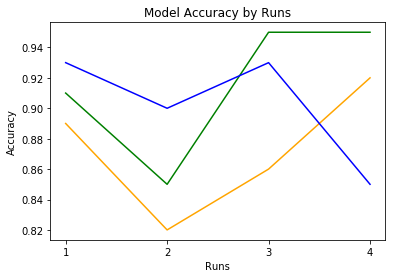

In [48]:
runs = [1, 2, 3, 4]
body_mdf_acc = [0.91, 0.85, 0.95, 0.95]
body_rnf_acc = [0.89, 0.82, 0.86, 0.92]
title_mdf_acc = [0.93, 0.9, 0.93, 0.85]
plt.plot(runs, body_mdf_acc, color='g')
plt.plot(runs, body_rnf_acc, color='orange')
plt.plot(runs, title_mdf_acc, color='blue')
plt.xticks(np.arange(min(runs), max(runs)+1, 1.0))
plt.xlabel('Runs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy by Runs')
plt.show()

#### Conclusion

According to the graph using BODY content with MultinomialNB will provide better predictions than the others.

Therefore we can predict the test set without labels like below. 

### Predicting Test Labels

In [49]:
# Parse using read_csv
news_without_labels = pd.read_csv('dataset/testsetwithoutlabels.txt', sep='\t', names=['TITLE', 'DATE', 'BODY'])

In [50]:
news_without_labels.head()

,TITLE,DATE,BODY
0,USSR WHEAT BONUS OFFER SAID STILL UNDER DEBATE,"WASHINGTON, March 6 -",The Reagan administration continues to debat...
1,HAITIAN CANE PLANTERS PROTEST SUGAR MILL CLOSURE,"PORT-AU-PRINCE, April 13 -","About 2,000 sugar cane planters marched to P..."
2,U.S. URGES JAPAN TO OPEN FARM MARKET FURTHER,"TOKYO, April 17 -",U.S. Agriculture Secretary Richard Lyng has ...
3,NORANDA COPPER MINE SHUT DOWN AFTER FIRE,"TORONTO, April 2 -",Noranda Inc said production at its Murdochvi...
4,17 MISSING NORANDA MINERS FOUND ALIVE,"MURDOCHVILLE, Que., April 2-",Seventeen miners who were missing in a coppe...


In [51]:
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),
    ('tfidf', TfidfTransformer()),
    ('classifier', MultinomialNB())
])

In [52]:
pipeline.fit(news_body_train,class_train)

Pipeline(memory=None,
     steps=[('bow', CountVectorizer(analyzer=<function text_process at 0x000001B85DCDFBF8>,
        binary=False, decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), preprocesso...f=False, use_idf=True)), ('classifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [53]:
predictions_final = pipeline.predict(news_without_labels['BODY'])

In [54]:
predictions_final

array([-1,  1,  1,  1,  1, -1,  1, -1,  1, -1, -1,  1,  1, -1,  1, -1, -1,
        1, -1,  1, -1, -1, -1, -1, -1,  1,  1,  1,  1, -1,  1, -1, -1, -1,
        1,  1, -1,  1, -1, -1, -1, -1,  1,  1, -1,  1, -1,  1, -1,  1, -1,
       -1, -1,  1, -1, -1,  1, -1, -1, -1,  1, -1, -1, -1,  1,  1, -1,  1,
       -1, -1,  1, -1,  1, -1,  1,  1, -1,  1, -1, -1,  1,  1,  1, -1,  1,
        1, -1,  1,  1, -1,  1, -1, -1,  1, -1,  1, -1, -1,  1, -1],
      dtype=int64)

#### Witing Predictions to CSV File

In [55]:
result = pd.DataFrame(data={'CLASS': predictions_final, 'TITLE': news_without_labels['TITLE'], 'DATE': news_without_labels['DATE'], 'BODY': news_without_labels['BODY']})
result.to_csv(path_or_buf='Final_Prediction.csv', index = False, header = True)

## Overall Conclusion

* In NLP **MultinomialNB** is better than **RandomForrestClassifier**.

* News cannot be classified upon content length.

* **Title** of the News and **Body** of the news are two successful features to classify a news article.

* From the above two features Body of the news is more helpful to correctly predict a category for a upcoming news article.

### About Class Labels

After a careful analysis we can come into the conclusion of **CLASS -1** being a **Economical** news and **CLASS +1** being a **Non Economical** News.


## Additional Material

Download the full `juputer notebook` using the following link or QR code.

[https://github.com/DevDHera/Guide-to-NLP-with-Python](https://github.com/DevDHera/Guide-to-NLP-with-Python)

<img src="./public/qr/QRcode.png">